# **RL In-Class Exercise 2 Tutorial 2**
This notebook contains the in-class exercise 2 from tutorial 2 of Deep Reinforcement Learning in AML.

# Exercise Overview

In the first in-class exercise, you implemented Actor-Critic. Now you'll extend it to PPO!

## What changes from Actor-Critic to PPO?

### Main differences:
1. **Clipped surrogate objective:** Prevent destructive policy updates
2. **Multiple epochs on same data:** Reuse collected experience
3. **Mini-batch updates:** Both actor and critic update together
4. **Entropy regularization:** Encourage exploration

### Exercises:

**Exercise 1:** Implement `get_log_prob()` - Extract log probability computation

**Exercise 2:** Implement `get_actor_loss()` - PPO clipped surrogate loss with entropy

**Exercise 3:** Modify `train_one_epoch()` - Mini-batches and multiple epochs

**Exercise 4:** Modify the training cell - Add PPO hyperparameters

# Install & Import Requirements



In [1]:
!pip install swig
!pip install gymnasium[box2d]

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [1]:
import torch
import torch.nn as nn
from torch.distributions.normal import Normal
from torch.optim import Adam
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from datetime import datetime
from typing import Sequence
from tqdm import tqdm

/home/lamberto/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# Helper functions

## MLP function to create the policy network of our agent

In [2]:
def mlp(sizes: Sequence[int], activation=nn.ReLU, output_activation=nn.Identity) -> nn.Sequential:
  """
      Create a simple feedforward neural network.
  """
  layers = []
  for j in range(len(sizes)-1):
    act = activation if j < len(sizes)-2 else output_activation
    layers += [nn.Linear(sizes[j], sizes[j+1]), act()]
  return nn.Sequential(*layers)

## Functions to get the ouput of the policy network

In [3]:
def get_policy(obs: torch.Tensor) -> Normal:
  """
  Get the stochastic policy for a given observation (-batch).
  Returns a distribution for every action-dimension.
  """
  obs = obs.unsqueeze(0) if obs.dim() == 1 else obs  # for single observations that do not have a batch dimension
  logits = actor(obs)
  mean, logstd = logits[:, :n_acts], logits[:, n_acts:]  # split the output layer into mean and logstd
  logstd = torch.clamp(logstd, min=-20, max=2)  # for numerical stability
  return Normal(mean, torch.exp(logstd))

In [4]:
def get_action(obs: torch.Tensor) -> np.ndarray:
  """
  Get the action (-batch) from the policy for a given observation (-batch).
  """
  dist = get_policy(obs)
  return dist.sample().squeeze(0).numpy()

## EXERCISE 1: Implement get_log_prob

In PPO, we need to compute log probabilities separately for importance sampling.

This function extracts the log probability computation.

In [5]:
def get_log_prob(obs: torch.Tensor, act: torch.Tensor) -> torch.Tensor:
  """
  Get the log-probability of a given action for a given observation.

  Args:
      obs: Observations tensor of shape (batch_size, obs_dim)
      act: Actions tensor of shape (batch_size, n_acts)

  Returns:
      log_probs: Log probabilities of shape (batch_size,)
  """
  dist = get_policy(obs)
  probs = dist.log_prob(act).sum(dim=-1)
  return probs

### Test Functions (Feel free to collapse this cell)

In [6]:
def test_get_log_prob(get_log_prob_fn):
    """
    Test the get_log_prob implementation.
    """
    # Create dummy actor network for testing
    global actor, n_acts
    n_acts = 2
    actor = mlp([8] + [64, 64] + [2*n_acts])

    results = []

    # Test 1: Output has correct shape
    try:
        obs = torch.randn(10, 8)
        act = torch.randn(10, 2)

        log_probs = get_log_prob_fn(obs, act)

        if log_probs.shape == torch.Size([10]):
            print("✓ Test 1: Output shape correct")
            results.append(True)
        else:
            print(f"✗ Test 1: Output shape should be (10,)")
            results.append(False)
    except Exception as e:
        print(f"✗ Test 1: Error - {type(e).__name__}")
        results.append(False)

    # Test 2: Output dtype is correct
    try:
        obs = torch.randn(10, 8)
        act = torch.randn(10, 2)

        log_probs = get_log_prob_fn(obs, act)

        if log_probs.dtype == torch.float32:
            print("✓ Test 2: Output dtype correct")
            results.append(True)
        else:
            print(f"✗ Test 2: Output dtype should be float32")
            results.append(False)
    except Exception as e:
        print(f"✗ Test 2: Error - {type(e).__name__}")
        results.append(False)

    # Test 3: Different actions produce different log probs
    try:
        torch.manual_seed(42)
        obs = torch.randn(10, 8)
        act1 = torch.randn(10, 2)
        act2 = torch.randn(10, 2)

        log_probs1 = get_log_prob_fn(obs, act1)
        log_probs2 = get_log_prob_fn(obs, act2)

        if not torch.allclose(log_probs1, log_probs2):
            print("✓ Test 3: Different actions produce different log probs")
            results.append(True)
        else:
            print("✗ Test 3: Different actions should produce different log probs")
            results.append(False)
    except Exception as e:
        print(f"✗ Test 3: Error - {type(e).__name__}")
        results.append(False)

    # Test 4: Works with single observation
    try:
        obs = torch.randn(1, 8)
        act = torch.randn(1, 2)

        log_probs = get_log_prob_fn(obs, act)

        if log_probs.shape == torch.Size([1]):
            print("✓ Test 4: Works with single observation")
            results.append(True)
        else:
            print("✗ Test 4: Should work with single observation")
            results.append(False)
    except Exception as e:
        print(f"✗ Test 4: Error - {type(e).__name__}")
        results.append(False)

    return sum(results), len(results)

### Run Tests

In [7]:
passed, total = test_get_log_prob(get_log_prob)
print(f"\n{'='*50}")
print(f"Results: {passed}/{total} tests passed")
if passed == total:
  print("🎉 All tests passed! You're ready to move on.")
else:
  print("⚠️  Some tests failed. Review your implementation.")

✓ Test 1: Output shape correct
✓ Test 2: Output dtype correct
✓ Test 3: Different actions produce different log probs
✓ Test 4: Works with single observation

Results: 4/4 tests passed
🎉 All tests passed! You're ready to move on.


## Function to compute GAE

In [8]:
def compute_gae(rewards: torch.Tensor,
                values: torch.Tensor,
                next_values: torch.Tensor,
                dones: torch.Tensor,  # values are either 1.0 (has ended) or 0.0 (has not ended), indicating whether an episode has ended or not.
                gamma=0.99,  # discount factor (0,1]
                lam=0.95,  # trace-decay parameter [0,1]. lam=0.0: temporal difference, lam=1.0: Monte Carlo
                ) -> torch.Tensor:
  """
  Compute the Generalized Advantage Estimation (GAE) used for the actor loss function.
  Balances the bias-variance tradeoff of the advantage estimates.
  lam=0.0: temporal difference, high bias - low variance
  lam=1.0: Monte Carlo, high variance - low bias
  """
  T = rewards.shape[0]
  advantages = torch.zeros_like(rewards)
  gae = 0.0
  for t in reversed(range(T)):
    nonterminal = 1.0 - dones[t]
    delta = rewards[t] + gamma * next_values[t] * nonterminal - values[t]
    gae = delta + gamma * lam * nonterminal * gae
    advantages[t] = gae
  return advantages

## EXERCISE 2: Modify get_actor_loss

PPO uses a clipped surrogate objective instead of vanilla policy gradient.

Key components:
1. Importance sampling ratio (for numerical stability we first calclate the log of the ratio)
2. Clipped ratio: prevents ratio from going too far from 1.0
3. Clipped objective
4. Entropy bonus: encourages exploration

You need to implement all of these components.

In [9]:
def get_actor_loss(obs: torch.Tensor, act: torch.Tensor, weights: torch.Tensor, old_logp: torch.Tensor, beta: float=0.00) -> torch.Tensor:
  """
  Compute the PPO clipped surrogate loss with entropy regularization for the actor.

  Args:
        obs: Observations tensor of shape (batch_size, obs_dim)
        act: Actions tensor of shape (batch_size, n_acts)
        weights: Advantage estimates of shape (batch_size,)
        old_logp: Log probabilities under old policy of shape (batch_size,)
        beta: Entropy regularization coefficient

    Returns:
        loss: Scalar loss tensor
  """
  dist = get_policy(obs)
  logp = get_log_prob(obs,act)
  # NOTE: Make importance weight
  ratio = torch.exp(logp - old_logp)
  # NOTE: In this case the weights are the advantages, should be negative but we handle in the return 
  clipped_obj = torch.min(ratio* weights, torch.clamp(ratio, 1- clip_ratio, 1+ clip_ratio) * weights).mean()
  entropy = dist.entropy().sum(dim=-1).mean()
  return - clipped_obj - beta*entropy

## Function to compute the discounted return

In [10]:
def discounted_return(arr: Sequence[float], gamma=0.99) -> list[float]:
  """
  Compute the discounted return for a single episode, given a sequence of rewards.
  gamma: discount factor (0,1]
  Used for the MSE loss function of the critic.
  """
  ret = [0.0] * len(arr)
  ret[-1] = arr[-1]
  for i in range(len(arr)-2, -1, -1):
    ret[i] = arr[i] + gamma * ret[i+1]
  return ret

## EXERCISE 3: Modify train_one_epoch

PPO makes several key changes to Actor-Critic's training:

1. Compute old_log_prob BEFORE any updates (for importance sampling)
2. Remove separate critic update loop
3. Add outer loop for multiple epochs (n_ppo_epochs)
4. Add inner loop for mini-batches with shuffling
5. Both actor and critic update in each mini-batch
6. Add gradient clipping for stability

In [15]:
def train_one_epoch() -> tuple[list, list]:
  """
  Train the actor and critic for one epoch,
  i.e. one actor-update and n_critic_updates critic-updates.
  """
  batch_obs = []
  batch_acts = []
  batch_rewards = []
  batch_next_obs = []
  batch_dones = []
  batch_rets = []
  batch_lens = []
  batch_Rtogo = []

  obs, _ = env.reset()
  ep_rews = []


  while True:
    act = get_action(torch.as_tensor(obs, dtype=torch.float32))
    next_obs, rew, terminated, truncated, _ = env.step(act)
    done = terminated or truncated

    batch_obs.append(obs.copy())  # copy as obs is modified in-place
    batch_acts.append(act)  # act is newly initialized every loop -> no copy
    batch_rewards.append(rew)
    batch_next_obs.append(next_obs.copy())
    batch_dones.append(done)
    ep_rews.append(rew)

    obs = next_obs

    if done:
      batch_rets.append(sum(ep_rews))
      batch_lens.append(len(ep_rews))
      batch_Rtogo += discounted_return(ep_rews, gamma=gamma)
      ep_rews = []
      obs, _ = env.reset()

      if len(batch_obs) > batch_size:
        break

  # convert lists to tensors
  batch_obs = torch.as_tensor(np.array(batch_obs), dtype=torch.float32)
  batch_next_obs = torch.as_tensor(np.array(batch_next_obs), dtype=torch.float32)
  batch_acts = torch.as_tensor(np.array(batch_acts), dtype=torch.float32)
  batch_rewards = torch.as_tensor(np.array(batch_rewards), dtype=torch.float32)
  batch_dones = torch.as_tensor(np.array(batch_dones), dtype=torch.float32)
  batch_Rtogo = torch.as_tensor(np.array(batch_Rtogo), dtype=torch.float32)

  V_target = batch_Rtogo.detach()  # target for critic, cannot have gradients

  # TODO: Remove the critic update here
  # DONE

  # calculate generalized advantage estimate GAE
  with torch.no_grad():  # advantages should never have gradients
    value = critic(batch_obs).squeeze()
    next_values = critic(batch_next_obs).squeeze()
    A_gae = compute_gae(batch_rewards, value, next_values, batch_dones, gamma=gamma, lam=lam)  # weight for actor loss function
  A_gae = ((A_gae - A_gae.mean()) / (A_gae.std() + 1e-8))

  # TODO: Remove the actor update here
  # DONE

  # TODO: Compute old_log_prob before any updates (for importance sampling)
  old_log_prob = get_log_prob(batch_obs,batch_acts).detach()

  # TODO: Add outer loop for multiple epochs (use n_ppo_epochs)
  # TODO: Inside outer loop, shuffle the data
  # Hint: Use torch.randperm(len(batch_obs)) to get shuffled indices
  for _ in range(n_ppo_epochs):
    indices = torch.randperm(len(batch_obs))

    # TODO: Add inner loop for mini-batches
    # Hint: Loop from 0 to len(batch_obs) with step size mini_batch_size
    # Hint: Get mini-batch indices: idx = indices[start:end]
    # Hint: Check if idx is not empty before processing
    for start in range(0,len(batch_obs),mini_batch_size):
      end = min(start + mini_batch_size, len(batch_obs))
      idx = indices[start:end]
      if len(idx) == 0:
        continue

      # TODO: Extract mini-batches for obs, acts, advantages, old_logp, V_target
      mb_obs = batch_obs[idx]
      mb_act = batch_acts[idx]
      mb_adv = A_gae[idx]
      mb_old_logp = old_log_prob[idx]
      mb_V_target = V_target[idx]


      # TODO: Actor update
      # Hint: Use get_actor_loss with mini-batch data
      # TODO: Add gradient clipping: nn.utils.clip_grad_norm_(actor.parameters(), 0.5)
      actor_optimizer.zero_grad()
      actor_loss = get_actor_loss(mb_obs,mb_act,mb_adv,mb_old_logp,beta=beta)
      actor_loss.backward()
      nn.utils.clip_grad_norm_(actor.parameters(), 0.5)
      actor_optimizer.step()

      # TODO: Critic update
      # Hint: Use mse loss with critic predictions and V_target
      # Hint: Use .flatten() instead of .squeeze() for robust handling
      # TODO: Add gradient clipping: nn.utils.clip_grad_norm_(critic.parameters(), 0.5)
      critic_optimizer.zero_grad()
      critic_loss = mse(critic(mb_obs).flatten(), mb_V_target.flatten())
      critic_loss.backward()
      nn.utils.clip_grad_norm_(critic.parameters(), 0.5)
      critic_optimizer.step()

    return batch_rets, batch_lens

# EXERCISE 4: Modify the training cell


Add PPO-specific hyperparameters and adjust the setup.

Changes needed:
1. Add: clip_ratio, n_ppo_epochs, mini_batch_size, beta
2. Remove: n_critic_updates (no longer separate)
3. Everything else stays the same!

100%|██████████| 10/10 [00:20<00:00,  2.02s/it, avg_ret=-143, avg_len=123]


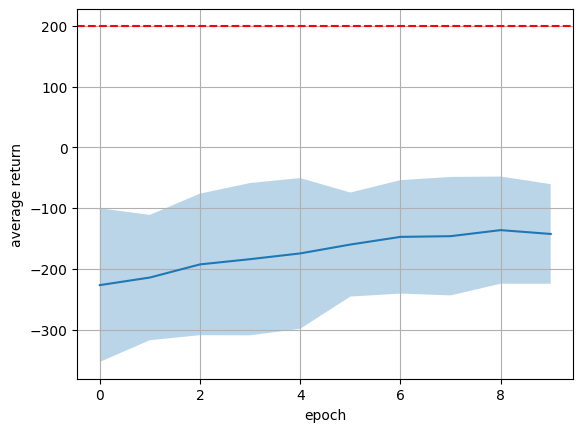

In [16]:

env_name='LunarLander-v3'
hidden_sizes=[64, 64]
lr=3e-4
lr_critic=1e-3
epochs=10
batch_size=5_000
gamma=0.99
# TODO: remove n_critic_updates
lam=0.95
plot=True
# TODO: Add hyperparameters
clip_ratio = 0.2
n_ppo_epochs = 10
mini_batch_size = 128
beta = 0.0 

env = gym.make(env_name, continuous=True) if env_name == "LunarLander-v3" else gym.make(env_name)  # BipedalWalker is continuous per default

obs_dim = env.observation_space.shape[0]
n_acts = env.action_space.shape[0]

actor = mlp([obs_dim]+hidden_sizes+[2*n_acts])  # output-layer: 2*n_acts, for mean and logstd as the policy is stochastic
critic = mlp([obs_dim]+hidden_sizes+[1])
actor_optimizer = Adam(actor.parameters(), lr=lr)
critic_optimizer = Adam(critic.parameters(), lr=lr_critic)
mse = nn.MSELoss()

returns = []
std = []

# training loop
progress_bar = tqdm(range(1, epochs+1))
for _ in progress_bar:
  batch_rets, batch_lens = train_one_epoch()
  avg_ret = np.mean(batch_rets)
  avg_len = np.mean(batch_lens)
  returns.append(avg_ret)
  std.append(np.std(batch_rets))
  progress_bar.set_postfix({"avg_ret": f"{avg_ret:5.0f}", "avg_len": f"{avg_len:5.0f}"})

if plot:
  plt.plot(returns)
  plt.fill_between(range(len(returns)), np.array(returns) - np.array(std), np.minimum(300, np.array(returns) + np.array(std)), alpha=0.3)
  plt.grid()
  goal = {"LunarLander-v3": 200, "BipedalWalker-v3": 300}.get(env_name, 0)
  plt.axhline(goal, color='r', linestyle='--')
  plt.xlabel('epoch')
  plt.ylabel('average return')
  timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
  # TODO: Change filename
  plt.savefig(f"PPO_training_{timestamp}.png")
  plt.show()